<a href="https://colab.research.google.com/github/armandoordonez/eda_couse/blob/main/Pipeline_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
# Based on https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

#Pipeline Experiment

In [2]:
df = pd.DataFrame(columns=['X1', 'X2', 'y'], data=[
                                                   [1,16,9],
                                                   [4,36,16],
                                                   [1,16,9],
                                                   [2,9,8],
                                                   [3,36,15],
                                                   [2,49,16],
                                                   [4,25,14],
                                                   [5,36,17]
])

### y = X1 + 2 * sqrt(X2)
# Esto asegura que un modelo de regresión lineal simple no pueda ajustarse perfectamente.

In [3]:
df

,X1,X2,y
0,1,16,9
1,4,36,16
2,1,16,9
3,2,9,8
4,3,36,15
5,2,49,16
6,4,25,14
7,5,36,17


In [4]:
# Separamos en train y test

train = df.iloc[:6]
test = df.iloc[6:]

train_X = train.drop('y', axis=1)
train_y = train.y

test_X = test.drop('y', axis=1)
test_y = test.y

In [5]:
test_X

,X1,X2
6,4,25
7,5,36


In [6]:
#  verificacmos si la regresión lineal puede predecir correctamente

m1 = LinearRegression()
fit1 = m1.fit(train_X, train_y)
preds = fit1.predict(test_X)
print(f"\n{preds}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds))}\n")


[13.72113586 16.93334467]
RMSE: 0.20274138822160603



In [7]:
# Las predicciones no son malas, pero hagamos algunos cálculos sobre las características de entrada para mejorar
# ¿Qué pasa si sacamos la raíz cuadrada de X2 y multiplicamos por 2?

train_X.X2 = 2 * np.sqrt(train_X.X2)

test_X.X2 = 2 * np.sqrt(test_X.X2)

print(test_X)

m2 = LinearRegression()

fit2 = m2.fit(train_X, train_y)

preds = fit2.predict(test_X)

print(f"\n{preds}")

print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds))}\n")

   X1    X2
6   4  10.0
7   5  12.0

[14. 17.]
RMSE: 0.0



In [ ]:
# una predicción perfecta, porque los datos después de la transformación se ajustan a una tendencia lineal perfecta.


In [8]:
# Restauremos los datos a sus valores originales y hagámoslo mediante transformadores personalizados mediante canalización.

train = df.iloc[:6]
test = df.iloc[6:]

train_X = train.drop('y', axis=1)
train_y = train.y

test_X = test.drop('y', axis=1)
test_y = test.y

In [9]:
# Creamos una clase transformadora

#__init__: este es el constructor. Se llama cuando se inicializa el pipeline.
#fit(): Se llama cuando hacemos fit en el pipeline.
#transform(): se llama cuando usamos fit o transform en el pipeline

class ExperimentalTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    print('\n>>>>>>>init() called.\n')

  def fit(self, X, y = None):
    print('\n>>>>>>>fit() called.\n')
    return self

  def transform(self, X, y = None):
    print('\n>>>>>>>transform() called.\n')
    X_ = X.copy() # creamos una copia para evitar cambios en el conjunto de datos original
    X_.X2 = 2 * np.sqrt(X_.X2)
    return X_

In [10]:
# sin transformación de entrada - para validar que obtenemos los mismos resultados que antes


print("create pipeline 1")
pipe1 = Pipeline(steps=[
                       ('linear_model', LinearRegression())
])

print("fit pipeline 1")
pipe1.fit(train_X, train_y)

print("predict via pipeline 1")
preds1 = pipe1.predict(test_X)

print(f"\n{preds1}")  # should be [13.72113586 16.93334467]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds1))}\n")

create pipeline 1
fit pipeline 1
predict via pipeline 1

[13.72113586 16.93334467]
RMSE: 0.20274138822160603



In [11]:
# con transformation de entradas

print("create pipeline 2")
pipe2 = Pipeline(steps=[
                       ('experimental_trans', ExperimentalTransformer()),    # esto dispara una llamda a __init__
                       ('linear_model', LinearRegression())
])

# una sintaxis alternativa y más corta para hacer lo anterior, sin nombrar cada paso, es:
#pipe2 = make_pipeline(ExperimentalTransformer(), LinearRegression())

print("fit pipeline 2")
pipe2.fit(train_X, train_y)

print("predict via pipeline 2")
preds2 = pipe2.predict(test_X)

print(f"\n{preds2}")  # should be [14. 17.]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds2))}\n")



# a. __init__ se llama cuando inicializamos pipe2.

# b. fit() y transform() se llaman cuando llamamos fit() con los datos de entrenamiento.
# Esto es necesario para transformar las características de entrada mientras se intenta predecir train_y.

# c. transform() se llama  cuando usamos predict(test_X): las características de prueba de entrada deben tener raíz cuadrada y duplicarse también antes de hacer predicciones.

create pipeline 2

>>>>>>>init() called.

fit pipeline 2

>>>>>>>fit() called.


>>>>>>>transform() called.

predict via pipeline 2

>>>>>>>transform() called.


[14. 17.]
RMSE: 0.0



In [12]:
# Hemos asumido en la función transform() de nuestro ExperimentalTransformer que el nombre de la columna es X2. No lo hagamos y
# pasar el nombre de la columna a través del constructor, __init__()

In [13]:
class ExperimentalTransformer_2(BaseEstimator, TransformerMixin):

  # agregue otro parámetro adicional, solo para mostrar su uso, mientras estamos en ello

  def __init__(self, feature_name, additional_param = "Pandebono"):
    print('\n>>>>>>>init() ExperimentalTransformer_2 called.\n')
    self.feature_name = feature_name
    self.additional_param = additional_param

  def fit(self, X, y = None):
    print('\n>>>>>>>fit() called.\n')
    print(f'\nadditional param ExperimentalTransformer_2 ~~~~~ {self.additional_param}\n')
    return self

  def transform(self, X, y = None):
    print('\n>>>>>>>transform() called.\n')
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    X_[self.feature_name] = 2 * np.sqrt(X_[self.feature_name])
    return X_

In [14]:
# tenga cuidado de mantener el nombre del parámetro exactamente igual en el argumento de la función, así como
# la variable de la clase (feature_name). Cambiar eso causará problemas más adelante cuando también
# intenta transformar la característica objetivo (y). Provoca una doble llamada a __init__ por algún motivo.

In [15]:
print("create pipeline 2")
pipe2 = Pipeline(steps=[
                       ('experimental_trans', ExperimentalTransformer_2('X2',additional_param='new')),
                       ('linear_model', LinearRegression())
])
print("fit pipeline 2")
pipe2.fit(train_X, train_y)
print("predict via pipeline 2")
preds2 = pipe2.predict(test_X)
print(f"\n{preds2}")  # should be [14. 17.]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds2))}\n")

create pipeline 2

>>>>>>>init() ExperimentalTransformer_2 called.

fit pipeline 2

>>>>>>>fit() called.


additional param ExperimentalTransformer_2 ~~~~~ new


>>>>>>>transform() called.

predict via pipeline 2

>>>>>>>transform() called.


[14. 17.]
RMSE: 0.0



In [17]:
# cuando es necesario realizar algún procesamiento previo y posterior
### sqrt(y) = X1 + 2 * sqrt(X2)
# Modificamos el dataframe  para que tenga el objetivo como cuadrados de los valores actuales:

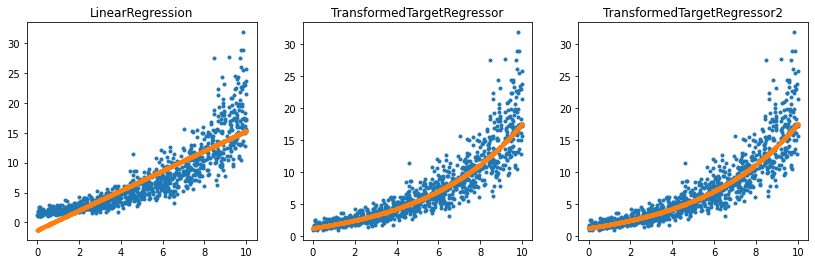

In [18]:

df = pd.DataFrame(columns=['X1', 'X2', 'y'], data=[
                                                   [1,16,81],
                                                   [4,36,256],
                                                   [1,16,81],
                                                   [2,9,64],
                                                   [3,36,225],
                                                   [2,49,256],
                                                   [4,25,196],
                                                   [5,36,289]
])

### sqrt(y) = X1 + 2 * sqrt(X2)
# formula de los datos

df


,X1,X2,y
0,1,16,81
1,4,36,256
2,1,16,81
3,2,9,64
4,3,36,225
5,2,49,256
6,4,25,196
7,5,36,289


In [19]:
train = df.iloc[:6]
test = df.iloc[6:]

train_X = train.drop('y', axis=1)
train_y = train.y

test_X = test.drop('y', axis=1)
test_y = test.y

In [ ]:
# let's see model's performance with no input & target transformations:
print("create pipeline 1")
pipe1 = Pipeline(steps=[
                       ('linear_model', LinearRegression())
])
print("fit pipeline 1")
pipe1.fit(train_X, train_y)
print("predict via pipeline 1")
preds1 = pipe1.predict(test_X)
print(f"\n{preds1}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds1))}\n")

create pipeline 1
fit pipeline 1
predict via pipeline 1

[200.34790002 279.04738423]
RMSE: 7.679804528409077



In [ ]:
# with input transformation but no target transformation
print("create pipeline 2")
pipe2 = Pipeline(steps=[
                       ('experimental_trans', ExperimentalTransformer_2('X2')),
                       ('linear_model', LinearRegression())
])
print("fit pipeline 2")
pipe2.fit(train_X, train_y)
print("predict via pipeline 2")
preds2 = pipe2.predict(test_X)
print(f"\n{preds2}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds2))}\n")

create pipeline 2

>>>>>>>init() called.

fit pipeline 2

>>>>>>>fit() called.


additional param ~~~~~ Pandebono


>>>>>>>transform() called.

predict via pipeline 2

>>>>>>>transform() called.


[207.42690058 280.94152047]
RMSE: 9.887192456534294



In [ ]:
# we'll now write a custom target transformer.
# this needs 2 functions, one to transform and another to inverse-transform

In [ ]:
def target_transform(target):
  print('\n*****************target_transform() called.\n')
  target_ = target.copy()
  target_ = np.sqrt(target_)
  return target_

def inverse_target_transform(target):
  print('\n*****************inverse_target_transform() called.\n')
  target_ = target.copy()
  target_ = target_ ** 2
  return target_

In [ ]:
# with input transformation & target transformation
print("create pipeline 3")
# no change in input pipeline
pipe3 = Pipeline(steps=[
                       ('experimental_trans', ExperimentalTransformer_2('X2')),
                       ('linear_model', LinearRegression())
])

# create a TargetTransformer
model = TransformedTargetRegressor(regressor=pipe3,
                                   func=target_transform,
                                   inverse_func=inverse_target_transform)

print("fit pipeline 3 [fit Model]")
# observe la sintaxis diferente aquí; ahora usamos model en lugar de 'pipe3'

model.fit(train_X, train_y)
print("predict via pipeline 3 [Model]")

preds3 = model.predict(test_X) # same here, using 'model' to predict
print(f"\n{preds3}")  # should be [196. 289.]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds3))}\n")

create pipeline 3

>>>>>>>init() called.

fit pipeline 3 [fit Model]

*****************target_transform() called.


*****************inverse_target_transform() called.


*****************target_transform() called.


*****************inverse_target_transform() called.


*****************target_transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


additional param ~~~~~ Pandebono


>>>>>>>transform() called.

predict via pipeline 3 [Model]

>>>>>>>transform() called.


*****************inverse_target_transform() called.


[196. 289.]
RMSE: 0.0



In [ ]:
#predicciones perfectas!

In [ ]:
# Podemos usar Transformers integrados en lugar de funciones definidas por el usuario. Ejemplo-
# model = TransformedTargetRegressor(regresor=pipe3, transformador=PowerTransformer())
# o
# model = TransformedTargetRegressor(regresor=pipe3, transformador=StandardScaler())
# El uso de un transformador incorporado no requiere que especifiquemos inverse_transformer() ya que eso se realiza internamente.

In [ ]:
# Es posible tener un transformador personalizado dentro de TransformedTargetRegressor
# El transformador personalizado es igual a los anteriores pero tendrá una función inverse_transform adicional
# Sólo se requiere implementar la función inverse_transform(). He aquí un ejemplo:

In [ ]:
class CustomTargetTransformer(BaseEstimator, TransformerMixin):
  # no need to implement __init__ in this particular case

  def fit(self, target):
    return self

  def transform(self, target):
    print('\n%%%%%%%%%%%%%%%custom_target_transform() called.\n')
    target_ = target.copy()
    target_ = np.sqrt(target_)
    return target_

  # need to implement this too
  def inverse_transform(self, target):
    print('\n%%%%%%%%%%%%%%%custom_inverse_target_transform() called.\n')
    target_ = target.copy()
    target_ = target_ ** 2
    return target_

In [ ]:
# with input transformation & target transformation
print("create pipeline 3.1")
# no change in input pipeline
pipe3_1 = Pipeline(steps=[
                       ('experimental_trans', ExperimentalTransformer_2('X2')),
                       ('linear_model', LinearRegression())
])

# create a TargetTransformer
# By default, the provided functions are checked at each fit to be the inverse of each other. However, it is
# possible to bypass this checking by setting check_inverse to False.
model = TransformedTargetRegressor(regressor=pipe3_1,
                                   transformer=CustomTargetTransformer(),
                                   check_inverse=False) # avoid repeated calls

print("fit pipeline 3.1 [fit Model]")
model.fit(train_X, train_y)
print("predict via pipeline 3.1 [Model]")
preds3_1 = model.predict(test_X)
print(f"\n{preds3_1}")  # should be [196. 289.]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds3_1))}\n")

create pipeline 3.1

>>>>>>>init() called.

fit pipeline 3.1 [fit Model]

%%%%%%%%%%%%%%%custom_target_transform() called.


>>>>>>>init() called.


>>>>>>>fit() called.


additional param ~~~~~ Pandebono


>>>>>>>transform() called.

predict via pipeline 3.1 [Model]

>>>>>>>transform() called.


%%%%%%%%%%%%%%%custom_inverse_target_transform() called.


[196. 289.]
RMSE: 0.0



In [ ]:
# veamos ahora cómo obtener y configurar los parámetros del modelo. También almacenaremos en caché el transformador en
# evitar cálculos repetidos y hacerlo más eficiente.

In [ ]:
# Obtener todos los parámetros de nuestro modelo
model.get_params()

{'check_inverse': False,
 'func': None,
 'inverse_func': None,
 'regressor__memory': None,
 'regressor__steps': [('experimental_trans',
   ExperimentalTransformer_2(feature_name='X2')),
  ('linear_model', LinearRegression())],
 'regressor__verbose': False,
 'regressor__experimental_trans': ExperimentalTransformer_2(feature_name='X2'),
 'regressor__linear_model': LinearRegression(),
 'regressor__experimental_trans__additional_param': 'Pandebono',
 'regressor__experimental_trans__feature_name': 'X2',
 'regressor__linear_model__copy_X': True,
 'regressor__linear_model__fit_intercept': True,
 'regressor__linear_model__n_jobs': None,
 'regressor__linear_model__positive': False,
 'regressor': Pipeline(steps=[('experimental_trans',
                  ExperimentalTransformer_2(feature_name='X2')),
                 ('linear_model', LinearRegression())]),
 'transformer': CustomTargetTransformer()}

In [ ]:
from tempfile import mkdtemp
from shutil import rmtree
# read about caching and side effect at: https://scikit-learn.org/stable/modules/compose.html?highlight=transformedtargetregressor#pipeline-chaining-estimators

In [ ]:
cachedir = mkdtemp()
print("create pipeline 4")
pipe4 = Pipeline(steps=[
                        # incorrect column name passed
                       ('experimental_trans', ExperimentalTransformer_2('X9')),  # Error
                       ('linear_model', LinearRegression())
], memory=cachedir)
# create a TargetTransformer
model = TransformedTargetRegressor(regressor=pipe4,
                                   func=target_transform,
                                   inverse_func=inverse_target_transform,
                                   check_inverse=False)
# correcting the column name using set_params()
model.set_params(regressor__experimental_trans__feature_name = 'X2')

print("fit pipeline 4 [fit Model]")
model.fit(train_X, train_y)

print("predict via pipeline 4 [Model]")
preds4 = model.predict(test_X)

print(f"\n{preds4}")  # should be [196. 289.]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds4))}\n")

# Clear the cache directory when you don't need it anymore
rmtree(cachedir)

create pipeline 4

>>>>>>>init() ExperimentalTransformer_2 called.

fit pipeline 4 [fit Model]

*****************target_transform() called.


>>>>>>>init() ExperimentalTransformer_2 called.


>>>>>>>init() ExperimentalTransformer_2 called.


>>>>>>>fit() called.


additional param ExperimentalTransformer_2 ~~~~~ Pandebono


>>>>>>>transform() called.

predict via pipeline 4 [Model]

>>>>>>>transform() called.


*****************inverse_target_transform() called.


[196. 289.]
RMSE: 0.0



In [ ]:
cachedir = mkdtemp()
print("create pipeline 4")
pipe4 = Pipeline(steps=[
                        # incorrect column name passed
                       ('experimental_trans', ExperimentalTransformer_2('X1')),
                       ('linear_model', LinearRegression())
], memory=cachedir)
# create a TargetTransformer
model = TransformedTargetRegressor(regressor=pipe4,
                                   func=target_transform,
                                   inverse_func=inverse_target_transform,
                                   check_inverse=False)
# correcting the column name using set_params()
model.set_params(regressor__experimental_trans__feature_name = 'X2')

print("fit pipeline 4 [fit Model]")
model.fit(train_X, train_y)
print("predict via pipeline 4 [Model]")
preds4 = model.predict(test_X)
print(f"\n{preds4}")  # should be [196. 289.]
print(f"RMSE: {np.sqrt(mean_squared_error(test_y, preds4))}\n")

# Clear the cache directory when you don't need it anymore
rmtree(cachedir)

create pipeline 4

>>>>>>>init() ExperimentalTransformer_2 called.

fit pipeline 4 [fit Model]

*****************target_transform() called.


>>>>>>>init() ExperimentalTransformer_2 called.


>>>>>>>init() ExperimentalTransformer_2 called.


>>>>>>>fit() called.


additional param ExperimentalTransformer_2 ~~~~~ Pandebono


>>>>>>>transform() called.

predict via pipeline 4 [Model]

>>>>>>>transform() called.


*****************inverse_target_transform() called.


[196. 289.]
RMSE: 0.0



In [ ]:
# PRÓXIMOS PASOS:

# 1. FeatureUnion y ColumnTransformer
# Algunos buenos ejemplos:

# https://scikit-learn.org/stable/modules/compose.html#featureunion-composite-feature-spaces
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer


# 2. Usando GridSearch con Pipelines

# https://scikit-learn.org/stable/auto_examples/compose/plot_feature_union.html?highlight=pipeline
